In [1]:
from cgtnnlib.AugmentedReLUNetwork import AugmentedReLUNetwork
from cgtnnlib.EvaluationParameters import EvaluationParameters
from cgtnnlib.ExperimentParameters import ExperimentParameters
from cgtnnlib.PlotParams import PlotParams
from cgtnnlib.Report import Report, eval_report_key
from cgtnnlib.TrainingParameters import TrainingParameters
from cgtnnlib.analyze import analyze_just_one
from cgtnnlib.common import DATASETS, LEARNING_RATE, eval_inner
from cgtnnlib.training import train_model_outer


REPORT = Report(dir="workbench/")
DATASET = DATASETS[2]
P = 0.5


MODEL_CONSTRUCTOR = AugmentedReLUNetwork

DATASET

Dataset(name='StudentPerformanceFactors.csv', learning_task=LearningTask(name='regression', criterion=MSELoss(), dtype=torch.float32), number=3, classes_count=1, data=DatasetData(train_dataset=<torch.utils.data.dataset.TensorDataset object at 0x188d8c500>, test_dataset=<torch.utils.data.dataset.TensorDataset object at 0x188054080>, train_loader=<torch.utils.data.dataloader.DataLoader object at 0x186747bf0>, test_loader=<torch.utils.data.dataloader.DataLoader object at 0x187687560>))

In [ ]:


for iteration in range(1, 11):
    model_path = f"workbench/WorkbenchModel{iteration}.pth"
    experiment_params = ExperimentParameters(
        iteration=iteration,
        p=P
    )
    training_params = TrainingParameters(
        dataset=DATASET,
        learning_task=DATASET.learning_task,
        experiment_params=experiment_params,
    )
    eval_params = EvaluationParameters(
        dataset=DATASET,
        model_path=model_path,
        experiment_parameters=experiment_params,
        report_key=eval_report_key(
            model_name=MODEL_CONSTRUCTOR.__name__,
            dataset_number=DATASET.number,
            p=P,
            iteration=iteration,
        )
    )
    model = MODEL_CONSTRUCTOR(
        inputs_count=DATASET.features_count,
        outputs_count=DATASET.classes_count,
        p=experiment_params.p,
    )

    train_model_outer(
        model=model,
        filename=model_path,
        epochs=5,
        training_params=training_params,
        experiment_params=experiment_params,
        learning_rate=LEARNING_RATE,
        report=REPORT,
        dry_run=False
    )

    eval_inner(
        eval_params=eval_params,
        experiment_params=experiment_params,
        constructor=MODEL_CONSTRUCTOR
    )

REPORT.see()
REPORT.save()

Evaluating model at WorkbenchModel10.pth...
Evaluation of regression (head):
   noise_factor        r2        mse
0          0.00 -0.303406  20.064426
1          0.04 -0.302263  20.046837
2          0.08 -0.305888  20.102633
3          0.12 -0.315960  20.257675
4          0.16 -0.323149  20.368349
Report workbench/report.json
started: '2024-12-01T15:51:15.577651'
loss_AugmentedReLUNetwork_3_p0.5_N1: list(2180 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N1: dict(...)
loss_AugmentedReLUNetwork_3_p0.5_N2: list(2180 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N2: dict(...)
loss_AugmentedReLUNetwork_3_p0.5_N3: list(2180 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N3: dict(...)
loss_AugmentedReLUNetwork_3_p0.5_N4: list(2180 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N4: dict(...)
loss_AugmentedReLUNetwork_3_p0.5_N5: list(2180 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N5: dict(...)
loss_AugmentedReLUNetwork_3_p0.5_N6: list(2180 items)
evaluate_AugmentedReLUNetwork_3_p0.5_N6: dict(...)
loss

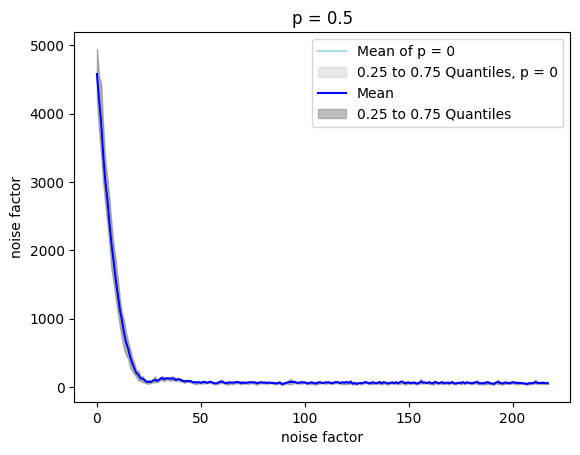

In [2]:
import matplotlib.pyplot as plt

from cgtnnlib.analyze import plot_curve_on_ax_or_plt

METRIC='loss'

curve = analyze_just_one(
    report_path=REPORT.path,
    plot_params=PlotParams(
        measurement=METRIC,
        dataset_number=DATASET.number,
        metric=METRIC,
        p=P,
        frac=0.1,
    )
)

plot_curve_on_ax_or_plt(
    ax_or_plt=plt,
    means=curve['mean'],
    lowerqs=curve[0.25],
    upperqs=curve[0.75],
    zmeans=curve['mean'], # XXX
    zlowerqs=curve[0.25], # XXX
    zupperqs=curve[0.75], # XXX
    X=curve.index,
    title=f'p = {P}',
    xlabel='noise factor',
    ylabel=METRIC,
)